### **Pemodelan Topik LDA dan Analisis Sentimen BERT Untuk Optimalisasi Kebijakan Green Economy dan Energi Baru Terbarukan (EBT) di Indonesia: Studi Media Sosial X**

 **1. Amanda Putri Aprilliani (105222001)**
 
 **2. Raihan Akira Rahmaputra (105222040)**

 **3. Gema Fitri Ramadani (105222009)**

 **4. Anom Wajawening (105222029)**

> 

----------

### **Scraping Tweet Social Media X** 

Kode ini mengimplementasikan proses pengumpulan data tweet menggunakan Twitter API v2 dengan library Tweepy untuk mengekstrak diskusi publik terkait Energi Baru Terbarukan (EBT) di Indonesia. 

Query pencarian menggunakan kombinasi kata kunci berbahasa Indonesia dan Inggris seperti "energi terbarukan", "solar panel", "ESDM", dan "climate change" dengan operator Boolean untuk memastikan relevansi data, serta memfilter tweet berbahasa Indonesia sambil mengecualikan retweet, reply, dan hashtag politik tertentu untuk menghindari bias.

Proses scraping dibatasi maksimal 1.000 tweet dengan pagination menggunakan next_token, dan setiap request diberi jeda 1 detik untuk menghindari rate limiting. Data yang dikumpulkan meliputi User ID, timestamp pembuatan tweet, teks tweet, dan URL tweet yang kemudian disimpan dalam format CSV dengan encoding UTF-8.

Pendekatan ini memungkinkan pengumpulan data real-time yang representatif untuk analisis sentimen dan pemodelan topik dalam konteks kebijakan energi terbarukan Indonesia.

In [ ]:
import tweepy
import pandas as pd
import time

# Ganti dengan Bearer token Anda
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAPhRxQEAAAAA3kbv2Jt6CIhlU07vAb8s4n3Vur4%3D34yjU0FdbFPHc3kOEzlLTz5gcP26IsAhwNM8RjhPnAr6frIR5R'

# Menggunakan Bearer token untuk otentikasi
client = tweepy.Client(bearer_token=bearer_token)

# Define search query
search_query = (
    '("renewable energy" OR "energi terbarukan" OR "EBT" OR "NRE" OR'
    '"energi baru" OR "solar panel" OR "panel surya" OR "wind power" OR'
    '"geothermal" OR "biomass" OR'
    '"ESDM" OR "Bahlil Lahadalia" OR "energi hidro" OR'
    '"PLTP" OR "energi bersih" OR "climate change" OR "deforestasi" OR'
    '"transisi energi" OR "energi hijau" OR'
    '"keberlanjutan energi")'
    '-is:retweet -is:reply (lang:id)'
    '-#SwasembadaEnergi -#PresidenPrabowo -#KetahananPangan -#AstaCita -#TransisiEnergi -#SobatNKRI'  # Contoh exclude hashtags
) # Ubah kata kunci yang mau diambil, gunakan logika AND dan OR dan pastikan data sudah tepat diambil
max_results = 100  # Maksimum 100 per permintaan
total_tweets = 0
attributes_container = []
next_token = None

try:
    while total_tweets < 1000:  # Batasi dulu maks 1000 tweet
        # Mengambil tweet menggunakan API v2
        response = client.search_recent_tweets(query=search_query, max_results=max_results, tweet_fields=['created_at', 'author_id'], next_token=next_token)

        # Memeriksa apakah ada tweet yang ditemukan
        if response.data:
            for tweet in response.data:
                tweet_url = f"https://twitter.com/twitter/status/{tweet.id}"
                attributes_container.append([tweet.author_id, tweet.created_at, tweet.text, tweet_url])
                total_tweets += 1  

        
        next_token = response.meta.get('next_token')
        if not next_token:
            break  

        # Menambahkan jeda untuk menghindari rate limit
        time.sleep(1)  # Jeda 1 detik antara permintaan

    
    columns = ["User   ID", "Date Created", "Tweet Text", "Tweet URL"] #tambahkan data geo
    tweets_df = pd.DataFrame(attributes_container, columns=columns)

    # Menampilkan DataFrame
    print(tweets_df)

    # Menyimpan DataFrame ke CSV dengan encoding UTF-8
    tweets_df.to_csv('hasil-scraping.csv', index=False, encoding='utf-8') 

except Exception as e:
    print('Status Failed On,', str(e))

ModuleNotFoundError: No module named 'tweepy'

### **EDA**

In [29]:
import pandas as pd
df = pd.read_csv('hasil-scraping.csv', encoding='utf-8')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User   ID     1095 non-null   int64 
 1   Date Created  1095 non-null   object
 2   Tweet Text    1095 non-null   object
 3   Tweet URL     1095 non-null   object
dtypes: int64(1), object(3)
memory usage: 34.3+ KB


In [31]:
df.head()

,User ID,Date Created,Tweet Text,Tweet URL
0,1666328210127327233,2025-01-02 08:18:21+00:00,Gas bumi adalah solusi energi bersih yang terj...,https://twitter.com/twitter/status/18747319460...
1,23343960,2025-01-02 08:13:32+00:00,Sejumlah dampak buruk dari deforestasi yang be...,https://twitter.com/twitter/status/18747307349...
2,1456213681176408067,2025-01-02 08:07:42+00:00,"kok iso dadi presiden ngene iki, aku ae sma ma...",https://twitter.com/twitter/status/18747292664...
3,1431858075565105163,2025-01-02 08:05:59+00:00,Gas bumi adalah solusi energi bersih yang terj...,https://twitter.com/twitter/status/18747288357...
4,1745850243269492736,2025-01-02 07:55:18+00:00,Belom jg 3 bulan ngejabat. Wowok and the gang ...,https://twitter.com/twitter/status/18747261435...


>---

### **Data Preprocessing**

In [32]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

**Kamus Slang Bahasa Indonesia**

Kamus ini didapatkan dari dataset yang dikirimkan ke LLM (Claude Sonnet 4) untuk dianalisis kira-kira apa saja slang dictionary yang dibutuhkan/disesuaikan dalam dataset project ini. 

In [33]:
# Indonesian slang dictionary - optimized untuk EBT context
INDONESIAN_SLANG_DICT = {
    # Basic slang normalization
    ' ga ': ' tidak ',
    ' gak ': ' tidak ',
    ' gk ': ' tidak ',
    ' yg ': ' yang ',
    ' udh ': ' sudah ',
    ' udah ': ' sudah ',
    ' bgt ': ' banget ',
    ' gmn ': ' bagaimana ',
    ' dmn ': ' dimana ',
    ' krn ': ' karena ',
    ' karna ': ' karena ',
    ' tp ': ' tapi ',
    ' hrs ': ' harus ',
    ' emg ': ' memang ',
    ' emang ': ' memang ',
    ' org ': ' orang ',
    ' dr ': ' dari ',
    ' dgn ': ' dengan ',
    ' utk ': ' untuk ',
    ' bs ': ' bisa ',
    ' jd ': ' jadi ',
    ' nggak ': ' tidak ',
    ' ngga ': ' tidak ',
    ' aja ': ' saja ',
    ' cuma ': ' hanya ',
    ' dah ': ' sudah ',
    ' tau ': ' tahu ',
    ' kalo ': ' kalau ',
    ' abis ': ' habis ',
    ' nih ': ' ini ',
    ' tuh ': ' itu ',
    ' yah ': ' ya ',
    ' kan ': ' kan ',
    ' kok ': ' kok ',
    # Energy/EBT specific
    ' pln ': ' PLN ',
    ' esdm ': ' ESDM ',
    ' ebt ': ' EBT ',
    ' plts ': ' PLTS ',
    ' pltp ': ' PLTP ',
    ' plta ': ' PLTA '
}

print(f"Slang dictionary created with {len(INDONESIAN_SLANG_DICT)} entries")

Slang dictionary created with 40 entries


**Hapus Tweet Duplikat**

In [34]:
def remove_duplicates(df, text_column='Tweet Text'):
    """Remove duplicate tweets"""
    print(f"Before removing duplicates: {len(df)} tweets")
    df_clean = df.drop_duplicates(subset=[text_column], keep='first')
    print(f"After removing duplicates: {len(df_clean)} tweets")
    print(f"Removed {len(df) - len(df_clean)} duplicate tweets")
    return df_clean

# Apply duplicate removal
df_step1 = remove_duplicates(df)

Before removing duplicates: 1095 tweets
After removing duplicates: 1094 tweets
Removed 1 duplicate tweets


**Menghapus url dengan [url]**

In [35]:
def clean_urls(text):
    text = re.sub(r'http\S+|https\S+|www\S+', '', text)  # Remove completely
    text = re.sub(r'\[URL\]', '', text)  # Remove [URL] tokens
    return text  # Return cleaned textcleaning

test_text = "Lihat artikel ini https://example.com tentang energi terbarukan"
print(f"Original: {test_text}")
print(f"Cleaned:  {clean_urls(test_text)}")

Original: Lihat artikel ini https://example.com tentang energi terbarukan
Cleaned:  Lihat artikel ini  tentang energi terbarukan


**Mengganti mention user dengan [USER]**

In [36]:
def clean_mentions(text):
    """Remove user mentions"""
    text = re.sub(r'@\w+', '[USER]', text)
    return text

# Test mention cleaning
test_text = "@jokowi Panel surya bagus untuk @indonesia"
print(f"Original: {test_text}")
print(f"Cleaned:  {clean_mentions(test_text)}")

Original: @jokowi Panel surya bagus untuk @indonesia
Cleaned:  [USER] Panel surya bagus untuk [USER]


**Menghapus hastag**

In [37]:
def clean_hashtags(text):
    """Clean hashtags - keep the text, remove the # symbol"""
    text = re.sub(r'#(\w+)', r'\1', text)
    return text

# Test hashtag cleaning
test_text = "Dukung #EnergiTerbarukan dan #PanelSurya untuk masa depan"
print(f"Original: {test_text}")
print(f"Cleaned:  {clean_hashtags(test_text)}")

Original: Dukung #EnergiTerbarukan dan #PanelSurya untuk masa depan
Cleaned:  Dukung EnergiTerbarukan dan PanelSurya untuk masa depan


**Menghapus tanda baca berlebihan**

In [38]:
def remove_excessive_punctuation(text):
    """Remove excessive punctuation while keeping meaning"""
    text = re.sub(r'[!]{2,}', '!', text)
    text = re.sub(r'[?]{2,}', '?', text)
    text = re.sub(r'[.]{3,}', '...', text)
    text = re.sub(r'[,]{2,}', ',', text)
    text = re.sub(r'[;]{2,}', ';', text)
    text = re.sub(r'[-]{3,}', '-', text)
    return text

# Test punctuation cleaning
test_text = "Wah bagus banget!!! Kok bisa??? Mantap..."
print(f"Original: {test_text}")
print(f"Cleaned:  {remove_excessive_punctuation(test_text)}")

Original: Wah bagus banget!!! Kok bisa??? Mantap...
Cleaned:  Wah bagus banget! Kok bisa? Mantap...


**Normalisasi spasi yang berlebih**

In [39]:
def normalize_whitespace(text):
    """Normalize whitespace and remove extra spaces"""
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Test whitespace normalization
test_text = "Panel   surya    sangat     bagus    untuk    masa   depan"
print(f"Original: '{test_text}'")
print(f"Cleaned:  '{normalize_whitespace(test_text)}'")

Original: 'Panel   surya    sangat     bagus    untuk    masa   depan'
Cleaned:  'Panel surya sangat bagus untuk masa depan'


**Normalisasi slang dengan bahasa indonesia**

In [40]:
def normalize_slang(text, slang_dict=INDONESIAN_SLANG_DICT):
    """Normalize Indonesian slang to formal words"""
    text_lower = text.lower()
    text_spaced = ' ' + text_lower + ' '
    
    for slang, formal in slang_dict.items():
        text_spaced = text_spaced.replace(slang.lower(), formal.lower())
    
    text_normalized = text_spaced.strip()
    return text_normalized

# Test slang normalization
test_text = "Panel surya yg udh dipasang ga mahal bgt kok"
print(f"Original: {test_text}")
print(f"Cleaned:  {normalize_slang(test_text)}")

Original: Panel surya yg udh dipasang ga mahal bgt kok
Cleaned:  panel surya yang sudah dipasang tidak mahal banget kok


**Menjalankan preprocessing**

In [41]:
def preprocess_text(text, keep_emojis=True):
    """
    Combined preprocessing function
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Apply all cleaning steps
    text = clean_urls(text)
    text = clean_mentions(text)
    text = clean_hashtags(text)
    
    
    text = remove_excessive_punctuation(text)
    text = normalize_whitespace(text)
    text = normalize_slang(text)
    text = normalize_whitespace(text)
    
    return text

# Test complete preprocessing
test_text = "Wah @jokowi panel surya yg udh dipasang bagus bgt!!! 😊 https://example.com #EBT"
print(f"Original:  {test_text}")
print(f"Processed: {preprocess_text(test_text)}")

Original:  Wah @jokowi panel surya yg udh dipasang bagus bgt!!! 😊 https://example.com #EBT
Processed: wah [user] panel surya yang sudah dipasang bagus bgt! 😊 ebt


In [42]:
# Apply preprocessing to all tweets
print("Applying preprocessing to all tweets...")
df_step1['Tweet Text_processed'] = df_step1['Tweet Text'].apply(
    lambda x: preprocess_text(x, keep_emojis=True)
)

print("Preprocessing completed!")
print(f"Dataset shape: {df_step1.shape}")

Applying preprocessing to all tweets...
Preprocessing completed!
Dataset shape: (1094, 5)


In [43]:
# Show before/after examples
print("="*80)
print("PREPROCESSING EXAMPLES:")
print("="*80)

n_examples = 5
for i in range(min(n_examples, len(df_step1))):
    original = df_step1.iloc[i]['Tweet Text']
    processed = df_step1.iloc[i]['Tweet Text_processed']

    print(f"\nExample {i+1}:")
    print("-" * 50)
    print(f"ORIGINAL:  {original}")
    print(f"PROCESSED: {processed}")

PREPROCESSING EXAMPLES:

Example 1:
--------------------------------------------------
ORIGINAL:  Gas bumi adalah solusi energi bersih yang terjangkau untuk rakyat Indonesia. ✨
__
Dengan kebijakan Bebas PPN sesuai PP No. 49 Tahun 2022, PGN memastikan tidak ada tambahan beban pajak bagi pelanggan kami:

#BUMNuntukIndonesia
#GASuntukRakyat
#Pertamina
#EnergizingYou https://t.co/QaYrJSKfn0
PROCESSED: gas bumi adalah solusi energi bersih yang terjangkau untuk rakyat indonesia. ✨ __ dengan kebijakan bebas ppn sesuai pp no. 49 tahun 2022, pgn memastikan tidak ada tambahan beban pajak bagi pelanggan kami: bumnuntukindonesia gasuntukrakyat pertamina energizingyou

Example 2:
--------------------------------------------------
ORIGINAL:  Sejumlah dampak buruk dari deforestasi yang berlebihan.

~N #Dampak #Deforestasi
https://t.co/KOxlrcOYaS
PROCESSED: sejumlah dampak buruk dari deforestasi yang berlebihan. ~n dampak deforestasi

Example 3:
--------------------------------------------------
ORIGI

**Kata-kata yang sering muncul**

In [44]:
# Analyze most common words after preprocessing
all_words = []
for text in df_step1['Tweet Text_processed']:
    if pd.notna(text):
        all_words.extend(text.split())

word_counts = Counter(all_words)
print("Top 20 most common words after preprocessing:")
for word, count in word_counts.most_common(20):
    print(f"{word}: {count}")

Top 20 most common words after preprocessing:
dan: 491
energi: 486
di: 459
yang: 437
untuk: 425
dengan: 405
deforestasi: 283
tidak: 268
tahun: 250
ini: 248
sawit: 243
baru: 230
dari: 169
pada: 169
erupsi: 166
kita: 164
rakyat: 163
bumi: 151
gas: 149
ada: 146


**Processed text disimpan dalam hasilscraping-processed.csv**

In [45]:
# Save processed dataset
output_filename = 'hasilscraping-processed.csv'
df_step1.to_csv(output_filename, index=False, encoding='utf-8')

print(f"Processed data saved to: {output_filename}")
print(f"Final dataset info:")
print(f"- Total tweets: {len(df_step1)}")
print(f"- Columns: {list(df_step1.columns)}")
print(f"- Ready for LDA, feature engineering and model training!")

Processed data saved to: hasilscraping-processed.csv
Final dataset info:
- Total tweets: 1094
- Columns: ['User   ID', 'Date Created', 'Tweet Text', 'Tweet URL', 'Tweet Text_processed']
- Ready for LDA, feature engineering and model training!


> -----

### **Topic Modelling dengan LDA**

**Import Library**

In [46]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pyLDAvis

**Load dataset hasilscraping-processed.csv**

In [47]:
# Load preprocessed data
df = pd.read_csv('hasilscraping-processed.csv')

print(f"Preprocessed data loaded!")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Use the processed text column
text_column = 'Tweet Text_processed'
texts = df[text_column].dropna().tolist()

print(f"\nTotal tweets for topic modeling: {len(texts)}")
print(f"Sample processed tweets:")
for i in range(3):
    print(f"{i+1}. {texts[i][:100]}...")

Preprocessed data loaded!
Shape: (1094, 5)
Columns: ['User   ID', 'Date Created', 'Tweet Text', 'Tweet URL', 'Tweet Text_processed']

Total tweets for topic modeling: 1094
Sample processed tweets:
1. gas bumi adalah solusi energi bersih yang terjangkau untuk rakyat indonesia. ✨ __ dengan kebijakan b...
2. sejumlah dampak buruk dari deforestasi yang berlebihan. ~n dampak deforestasi...
3. kok iso dadi presiden ngene iki, aku ae sma makalah ku bahas deforestasi hutan...


**Preprocessed untuk LDA, Mengubah data teks menjadi format numerik (Document-Term Matrix)**

In [48]:
# Prepare text data for LDA
def prepare_text_for_lda(texts, max_features=800, min_df=3, max_df=0.8):
    """
    Prepare text for LDA using CountVectorizer
    """
    # Use CountVectorizer for LDA
    vectorizer = CountVectorizer(
        max_features=max_features,
        ngram_range=(1, 2),  # Unigrams and bigrams
        min_df=min_df,       # Ignore terms that appear in less than min_df documents
        max_df=max_df,       # Ignore terms that appear in more than max_df of documents
        stop_words=None,     # We already cleaned in preprocessing
        lowercase=True,
        token_pattern=r'\b[a-zA-Z][a-zA-Z]+\b'  # Only alphabetic tokens, min 2 chars
    )
    
    doc_term_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"Document-term matrix shape: {doc_term_matrix.shape}")
    print(f"Vocabulary size: {len(feature_names)}")
    
    return doc_term_matrix, vectorizer, feature_names

# Create document-term matrix
doc_term_matrix, vectorizer, feature_names = prepare_text_for_lda(texts)

# Show top terms by frequency
term_freq = doc_term_matrix.sum(axis=0).A1
term_freq_df = pd.DataFrame({
    'term': feature_names,
    'frequency': term_freq
}).sort_values('frequency', ascending=False)

print("\nTop 20 most frequent terms:")
print(term_freq_df.head(20))

Document-term matrix shape: (1094, 800)
Vocabulary size: 800

Top 20 most frequent terms:
            term  frequency
197       energi        506
117          dan        493
161           di        463
137  deforestasi        459
793         yang        439
766        untuk        425
145       dengan        406
57          baru        371
632        sawit        306
274          ini        290
748        tidak        275
706        tahun        254
268    indonesia        226
198  energi baru        173
483         pada        172
129         dari        169
604       rakyat        168
352         kita        168
211       erupsi        166
282          itu        155


**Menentukan jumlah topik yang optimal untuk model LDA**
1. Metrik Perplexity (Keheranan) : mengukur seberapa baik model yang sudah dilatih dapat memprediksi data baru (data yang tidak terlihat). Nilai yang lebih rendah lebih baik. Skala perplexity dari 1 hingga tak terhingga.
2. Coherence (Koherensi/kerelevanan) : mengukur sebarapa masuk akal topik yang dihasilkan bagi manusia. Nilai yang lebih tinggi lebih baik.


Computing coherence scores for different topic numbers...
Testing 5 topics...
Testing 7 topics...
Testing 9 topics...
Testing 11 topics...


<Figure size 1200x600 with 0 Axes>

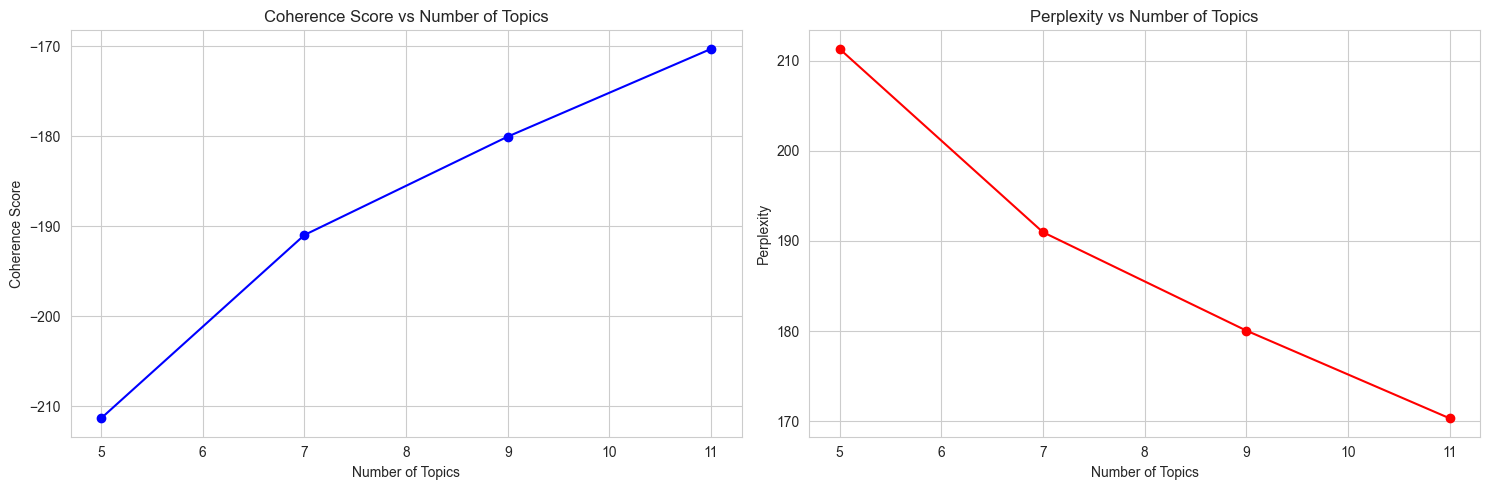


Optimal number of topics: 11


In [49]:
# Set style seaborn untuk tampilan bersih
sns.set_style("whitegrid")

# Buat plot dengan warna yang profesional
plt.figure(figsize=(12, 6))

def compute_coherence_scores(doc_term_matrix, vectorizer, topic_range):
    """
    Compute coherence scores for different numbers of topics
    """
    coherence_scores = []
    perplexity_scores = []
    
    for n_topics in topic_range:
        print(f"Testing {n_topics} topics...")
        
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            max_iter=100,
            learning_method='batch',
            n_jobs=-1
        )
        
        lda.fit(doc_term_matrix)
        
        # Calculate perplexity (lower is better)
        perplexity = lda.perplexity(doc_term_matrix)
        perplexity_scores.append(perplexity)
        
        coherence_scores.append(-perplexity) 
    
    return coherence_scores, perplexity_scores

# Test different numbers of topics
topic_range = range(5, 13, 2)  
print("Computing coherence scores for different topic numbers...")
coherence_scores, perplexity_scores = compute_coherence_scores(doc_term_matrix, vectorizer, topic_range)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot coherence scores
ax1.plot(topic_range, coherence_scores, 'bo-')
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence Score')
ax1.set_title('Coherence Score vs Number of Topics')
ax1.grid(True)

# Plot perplexity scores
ax2.plot(topic_range, perplexity_scores, 'ro-')
ax2.set_xlabel('Number of Topics')
ax2.set_ylabel('Perplexity')
ax2.set_title('Perplexity vs Number of Topics')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find optimal number of topics
optimal_idx = np.argmax(coherence_scores)
optimal_topics = list(topic_range)[optimal_idx]
print(f"\nOptimal number of topics: {optimal_topics}")

1. Grafik coherence score (kiri) : Grafik ini menunjukkan skor tertinggi (puncak) saat jumlah topik adalah 11. Hal ini mengindikasikan bahwa dengan 11 topik, kata-kata dalam setiap topik paling relevan dan topik-topiknya paling mudah dibedakan maknanya.
2. Grafik Perplexity (kanan) : Nilai perplexity terus menurun dan mencapai titik terendahnya pada 11 topik. Hal ini mendukung bahwa model lebih "percaya diri" dan tidak "bingung" saat memodelkan data dengan 11 topik.

**Training LDA**

In [50]:
# Train LDA with optimal number of topics
def train_lda_model(doc_term_matrix, n_topics, random_state=42):
    """
    Train final LDA model
    """
    lda_model = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=random_state,
        max_iter=100,
        learning_method='batch',
        doc_topic_prior=None,  # Use 1/n_topics
        topic_word_prior=None, # Use 1/n_topics
        n_jobs=-1
    )
    
    print(f"Training LDA model with {n_topics} topics...")
    lda_model.fit(doc_term_matrix)
    
    # Calculate final scores
    perplexity = lda_model.perplexity(doc_term_matrix)
    log_likelihood = lda_model.score(doc_term_matrix)
    
    print(f"Model training completed!")
    print(f"Perplexity: {perplexity:.4f}")
    print(f"Log-likelihood: {log_likelihood:.4f}")
    
    return lda_model

# Train final model
final_lda = train_lda_model(doc_term_matrix, optimal_topics)

Training LDA model with 11 topics...
Model training completed!
Perplexity: 170.3105
Log-likelihood: -146668.8655


1. Perplexity: 170.3105

Ini adalah skor "kebingungan" final dari model LDA. Angka ini tidak dinilai "baik" atau "buruk" secara tunggal, namun angka inilah skor terbaik (terendah) yang dicapai selama proses pengujian untuk memilih jumlah topik.

2. Log-likelihood: -146668.8655

Ini adalah skor yang mengukur seberapa baik model "cocok" (fit) dengan data. Semakin tinggi nilainya (semakin dekat ke nol), semakin baik. Angka ini mewakili kecocokan terbaik yang bisa dicapai model dengan 11 topik.

**Menampilkan topik dari hasil LDA**

In [51]:
def display_topics(lda_model, feature_names, n_top_words=10):
    """
    Display topics with their top words
    """
    topics = []
    
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        top_weights = [topic[i] for i in top_words_idx]
        
        topics.append({
            'topic_id': topic_idx,
            'words': top_words,
            'weights': top_weights
        })
        
        print(f"\nTopic {topic_idx}:")
        print(f"Top words: {', '.join(top_words[:8])}")
        
        # Create word-weight pairs
        word_weights = [(word, weight) for word, weight in zip(top_words, top_weights)]
        for word, weight in word_weights[:5]:
            print(f"  {word}: {weight:.4f}")
    
    return topics

# Display topics
topics = display_topics(final_lda, feature_names, n_top_words=15)


Topic 0:
Top words: kita, dari, untuk, dengan, sebuah, baru, ini, perubahan
  kita: 92.0922
  dari: 87.6945
  untuk: 85.8013
  dengan: 84.5791
  sebuah: 82.0909

Topic 1:
Top words: baru, tahun, energi, dan, tahun baru, energi baru, dengan, yang
  baru: 236.6356
  tahun: 124.0475
  energi: 112.3997
  dan: 99.8641
  tahun baru: 86.1290

Topic 2:
Top words: kelapa, kelapa sawit, dan, energi, baru, terbarukan, energi baru, usah
  kelapa: 87.3367
  kelapa sawit: 83.6540
  dan: 74.8589
  energi: 69.2028
  baru: 37.4626

Topic 3:
Top words: rakyat, bumi, gas, untuk rakyat, untuk, gas bumi, energi, yang
  rakyat: 76.2328
  bumi: 73.5749
  gas: 68.2827
  untuk rakyat: 65.1836
  untuk: 63.2910

Topic 4:
Top words: erupsi, di, user, via, via user, hari, dan, pada
  erupsi: 166.0909
  di: 121.7105
  user: 103.1926
  via: 88.0909
  via user: 88.0909

Topic 5:
Top words: untuk, rakyat, gas, untuk rakyat, gas bumi, bumi, ppn, no
  untuk: 92.5094
  rakyat: 91.9490
  gas: 80.8991
  untuk rakyat: 79.9

#### **Analisis Core Themes**

1. ENERGY_TECHNOLOGY (Topics 1, 6)
* Fokus pada aspek teknologi energi terbarukan
* Mencakup diskusi tentang energi baru dan transisi energi di Indonesia
* Melibatkan pembicaraan tentang PLN dan infrastruktur energi


2. ENVIRONMENTAL_IMPACT (Topics 2, 8, 10)
* Fokus pada dampak lingkungan, terutama deforestasi dan kelapa sawit
* Mencakup perdebatan tentang keberlanjutan lingkungan
* Melibatkan isu-isu kontroversial terkait sawit dan penggundulan hutan


3. GOVERNMENT_POLICY (Topics 7, 9)
* Fokus pada kebijakan pemerintah dan lembaga terkait
* Mencakup diskusi tentang ESDM, menteri, dan tokoh politik (Bahlil Lahadalia)
* Melibatkan aspek regulasi dan administrasi energi

4. ENERGY_ACCESS (Topics 3, 5)
* Fokus pada akses energi untuk masyarakat
* Mencakup diskusi tentang gas bumi untuk rakyat dan kebijakan terkait
* Melibatkan aspek keadilan sosial dan pemerataan energi


5. OTHER (Topics 0, 4)
* Kategori untuk topik-topik umum atau noise
* Mencakup kata-kata umum atau topik yang kurang spesifik

### **Kategorisasi Topik**

**Import Library**

In [54]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess

In [55]:
# Set style seaborn untuk tampilan bersih
sns.set_style("whitegrid")

# Buat plot dengan warna yang profesional
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

**Menerapkan core theme/topik utama LDA ke dalam data**

Distribusi Core Themes:
Core_Theme
ENVIRONMENTAL_IMPACT    502
ENERGY_TECHNOLOGY       201
GOVERNMENT_POLICY       153
OTHER                   133
ENERGY_ACCESS           105
Name: count, dtype: int64


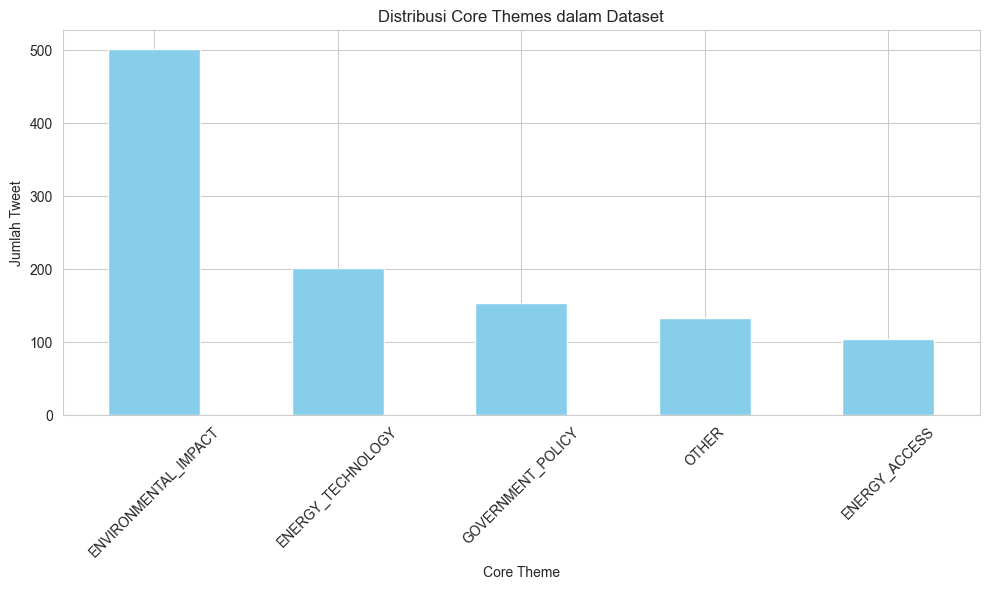

In [56]:
# Langkah 1: Memetakan topik dominan ke dalam dokumen
def get_dominant_topic(lda_model, doc_term_matrix, texts):
    # Transformasi dokumen ke topik
    topic_distributions = lda_model.transform(doc_term_matrix)
    
    dominant_topics = []
    for i, topic_dist in enumerate(topic_distributions):
        # Mendapatkan topik dengan probabilitas tertinggi
        dominant_topic = topic_dist.argmax()
        dominant_topics.append({
            'Document_Id': i,
            'Dominant_Topic': dominant_topic,
            'Topic_Prob': topic_dist[dominant_topic],
            'Text': texts[i]
        })
    return dominant_topics

# Mendapatkan topik dominan untuk setiap dokumen
dominant_topics = get_dominant_topic(final_lda, doc_term_matrix, df['Tweet Text_processed'].tolist())

# Membuat DataFrame hasil
results = pd.DataFrame(dominant_topics)

# Langkah 2: Tambahkan kategori ke DataFrame hasil topik
def assign_core_theme(topic_idx):
    core_themes = {
        'ENERGY_TECHNOLOGY': [1, 6],
        'ENVIRONMENTAL_IMPACT': [2, 8, 10],
        'GOVERNMENT_POLICY': [7, 9],
        'ENERGY_ACCESS': [3, 5],
        'OTHER': [0, 4]
    }
    
    for theme, topics in core_themes.items():
        if topic_idx in topics:
            return theme
    return "UNDEFINED"

# Terapkan ke DataFrame hasil LDA
results['Core_Theme'] = results['Dominant_Topic'].apply(assign_core_theme)

# Analisis distribusi core themes
theme_distribution = results['Core_Theme'].value_counts()
print("Distribusi Core Themes:")
print(theme_distribution)

# Visualisasi distribusi core themes
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
theme_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribusi Core Themes dalam Dataset')
plt.xlabel('Core Theme')
plt.ylabel('Jumlah Tweet')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('core_themes_distribution.png')
plt.show()

# Gabungkan hasil dengan DataFrame asli
df_with_topics = pd.merge(df, results[['Document_Id', 'Dominant_Topic', 'Core_Theme']], 
                         left_index=True, right_on='Document_Id', how='left')

# Simpan hasil
df_with_topics.to_csv('hasil_dengan_topik.csv', index=False)

In [57]:
core_themes = {
    'ENERGY_TECHNOLOGY': [1, 6],
    'ENVIRONMENTAL_IMPACT': [2, 8, 10],
    'GOVERNMENT_POLICY': [7, 9],
    'ENERGY_ACCESS': [3, 5],
    'OTHER': [0, 4]
}

**Distribusi topik per core themes**

In [58]:
# Analisis distribusi topik per core theme
print("\nDistribusi Topik per Core Theme:")
for theme in core_themes.keys():
    theme_docs = results[results['Core_Theme'] == theme]
    print(f"\n{theme}:")
    print(theme_docs['Dominant_Topic'].value_counts())


Distribusi Topik per Core Theme:

ENERGY_TECHNOLOGY:
Dominant_Topic
6    115
1     86
Name: count, dtype: int64

ENVIRONMENTAL_IMPACT:
Dominant_Topic
8     421
10     53
2      28
Name: count, dtype: int64

GOVERNMENT_POLICY:
Dominant_Topic
9    92
7    61
Name: count, dtype: int64

ENERGY_ACCESS:
Dominant_Topic
5    57
3    48
Name: count, dtype: int64

OTHER:
Dominant_Topic
4    87
0    46
Name: count, dtype: int64


### **Evaluasi Model LDA Menggunakan Metrik C-v dan UMass**

In [59]:
import numpy as np
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

texts = [doc.split() for doc in df['Tweet Text_processed']]
dictionary = Dictionary(texts)

topics = []
for topic_idx, topic in enumerate(final_lda.components_):
    top_words_idx = topic.argsort()[-10:][::-1]  # 10 kata teratas
    top_words = [feature_names[i] for i in top_words_idx]
    topics.append(top_words)

# Hitung coherence score dengan metode yang berbeda
coherence_cv = CoherenceModel(topics=topics, texts=texts, 
                             dictionary=dictionary, coherence='c_v')
c_v = coherence_cv.get_coherence()

coherence_umass = CoherenceModel(topics=topics, texts=texts, 
                                dictionary=dictionary, coherence='u_mass')
c_umass = coherence_umass.get_coherence()

print(f"Coherence Score (C_v): {c_v:.4f}")
print(f"Coherence Score (UMass): {c_umass:.4f}")

Coherence Score (C_v): 0.6576
Coherence Score (UMass): -3.3650


* Coherence Skor (C_v) : 0.6576. Skor ini tergolong tinggi, mengonfirmasi bahwa topik-topik yang dihasilkan sangat koheren dan kata-kata di dalamnya berhubungan secara semantik (makna).
* Coherence Skor (UMass) : -3.3650. Untuk UMass, nilai yang lebih dekat ke nol dianggap lebih baik. Hasil ini memberikan validasi tambahan dari sudut pandang metrik yang berbeda.

**Visualisasi wordcloud**

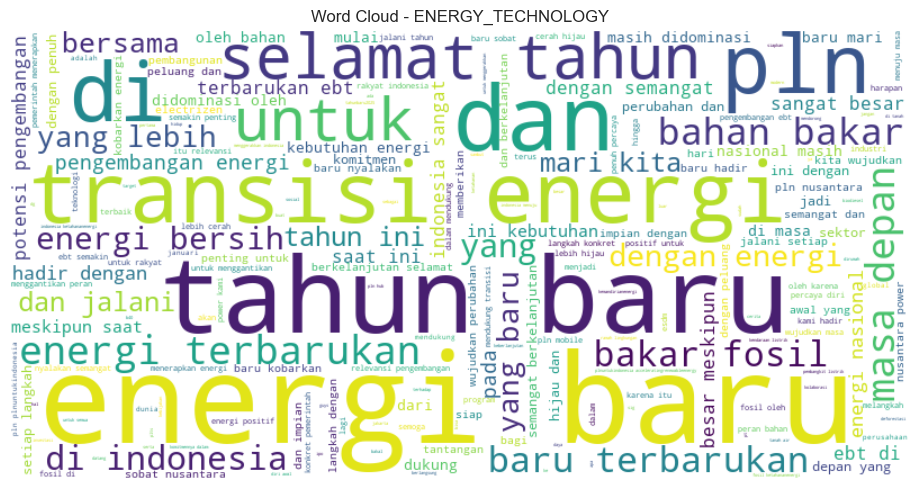

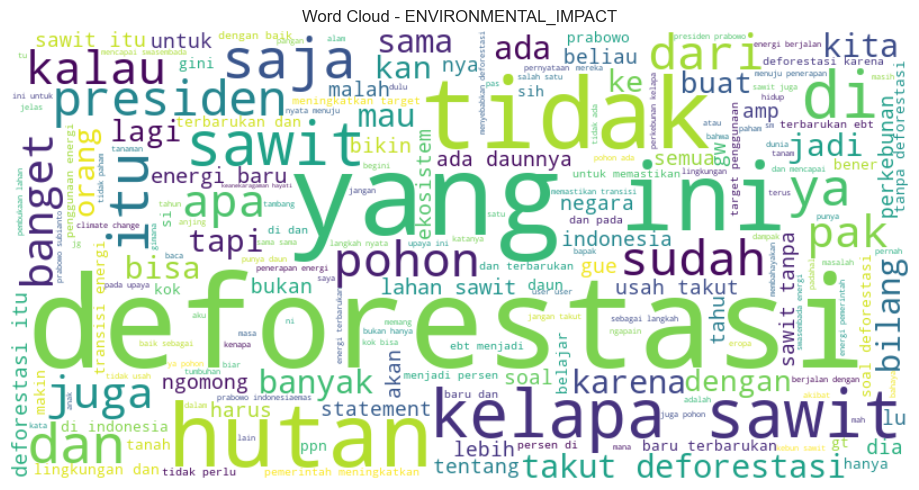

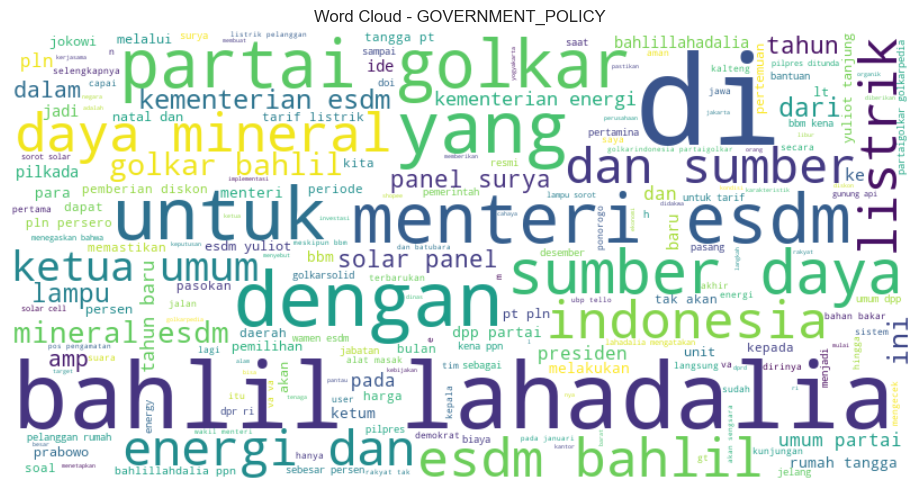

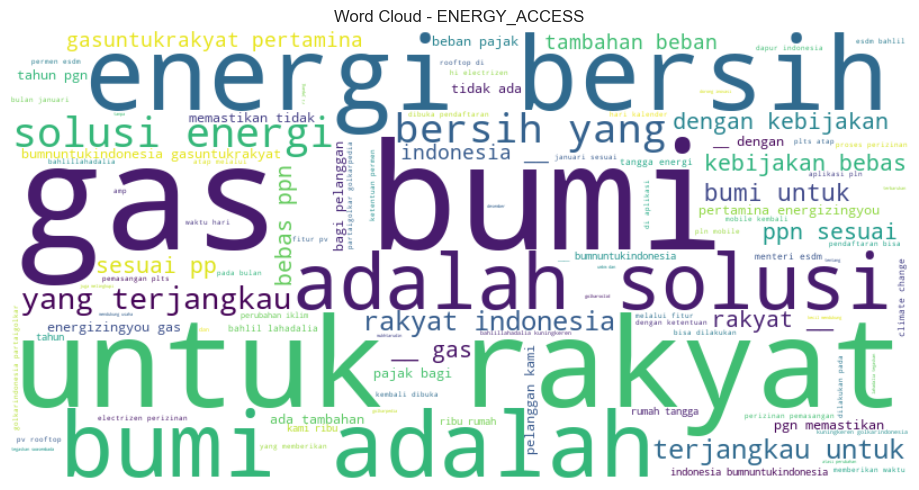

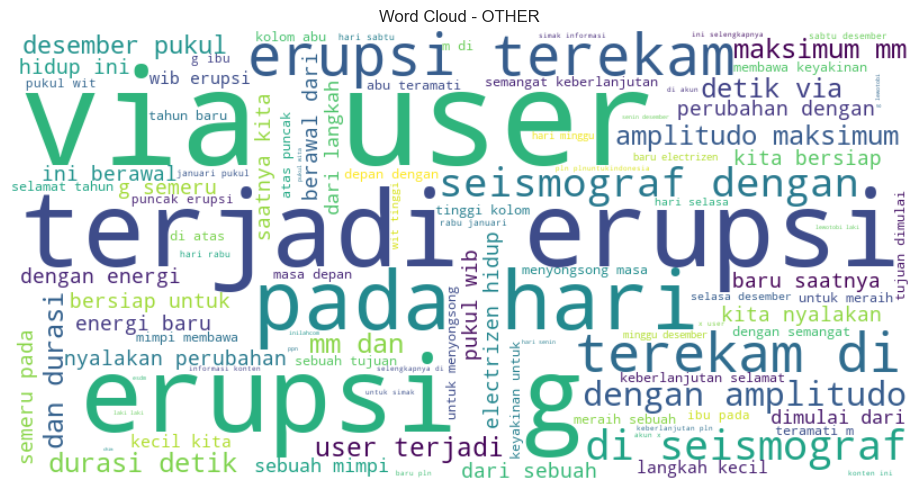

In [60]:
# Visualisasi wordcloud per core theme
from wordcloud import WordCloud

for theme in core_themes.keys():
    theme_docs = results[results['Core_Theme'] == theme]
    theme_texts = ' '.join(theme_docs['Text'].tolist())
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(theme_texts)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - {theme}')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'wordcloud_{theme}.png')
    plt.show()

### **Feature Engineering**

**Preprocessing sebelum masuk ke labeling**

In [61]:
def prepare_for_bert(text):
    # Hapus karakter khusus yang mungkin mengganggu tokenisasi
    text = re.sub(r'[^\w\s]', ' ', text)
    # Hapus multiple spaces
    
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text
    
df_sentiment = df_with_topics.copy()
df_sentiment['Text_for_BERT'] = df_sentiment['Tweet Text_processed'].apply(prepare_for_bert)

In [62]:
df_sentiment

,User ID,Date Created,Tweet Text,Tweet URL,Tweet Text_processed,Document_Id,Dominant_Topic,Core_Theme,Text_for_BERT
0,1666328210127327233,2025-01-02 08:18:21+00:00,Gas bumi adalah solusi energi bersih yang terj...,https://twitter.com/twitter/status/18747319460...,gas bumi adalah solusi energi bersih yang terj...,0,5,ENERGY_ACCESS,gas bumi adalah solusi energi bersih yang terj...
1,23343960,2025-01-02 08:13:32+00:00,Sejumlah dampak buruk dari deforestasi yang be...,https://twitter.com/twitter/status/18747307349...,sejumlah dampak buruk dari deforestasi yang be...,1,8,ENVIRONMENTAL_IMPACT,sejumlah dampak buruk dari deforestasi yang be...
2,1456213681176408067,2025-01-02 08:07:42+00:00,"kok iso dadi presiden ngene iki, aku ae sma ma...",https://twitter.com/twitter/status/18747292664...,"kok iso dadi presiden ngene iki, aku ae sma ma...",2,8,ENVIRONMENTAL_IMPACT,kok iso dadi presiden ngene iki aku ae sma mak...
3,1431858075565105163,2025-01-02 08:05:59+00:00,Gas bumi adalah solusi energi bersih yang terj...,https://twitter.com/twitter/status/18747288357...,gas bumi adalah solusi energi bersih yang terj...,3,5,ENERGY_ACCESS,gas bumi adalah solusi energi bersih yang terj...
4,1745850243269492736,2025-01-02 07:55:18+00:00,Belom jg 3 bulan ngejabat. Wowok and the gang ...,https://twitter.com/twitter/status/18747261435...,belom jg 3 bulan ngejabat. wowok and the gang ...,4,8,ENVIRONMENTAL_IMPACT,belom jg 3 bulan ngejabat wowok and the gang s...
...,...,...,...,...,...,...,...,...,...
1089,1481974206959169536,2024-12-28 19:37:18+00:00,Babu Ruwanka da NEPA Emergency Solar Panel Cha...,https://twitter.com/twitter/status/18730908713...,babu ruwanka da nepa emergency solar panel cha...,1089,9,GOVERNMENT_POLICY,babu ruwanka da nepa emergency solar panel cha...
1090,1701789907549835264,2024-12-28 15:18:17+00:00,Pemerintah berkomitmen untuk terus mendorong t...,https://twitter.com/twitter/status/18730256862...,pemerintah berkomitmen untuk terus mendorong t...,1090,6,ENERGY_TECHNOLOGY,pemerintah berkomitmen untuk terus mendorong t...
1091,1593171387057049600,2024-12-28 15:16:06+00:00,Mukhtarudin Dukung Langkah Menteri ESDM Tolak ...,https://twitter.com/twitter/status/18730251393...,mukhtarudin dukung langkah menteri esdm tolak ...,1091,3,ENERGY_ACCESS,mukhtarudin dukung langkah menteri esdm tolak ...
1092,1615747829422764033,2024-12-28 14:42:33+00:00,PLN optimistis dapat mewujudkan sistem kelistr...,https://twitter.com/twitter/status/18730166928...,pln optimistis dapat mewujudkan sistem kelistr...,1092,6,ENERGY_TECHNOLOGY,pln optimistis dapat mewujudkan sistem kelistr...


In [63]:
df = pd.read_csv('hasilscraping-processed.csv')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   User   ID             1094 non-null   int64 
 1   Date Created          1094 non-null   object
 2   Tweet Text            1094 non-null   object
 3   Tweet URL             1094 non-null   object
 4   Tweet Text_processed  1094 non-null   object
dtypes: int64(1), object(4)
memory usage: 42.9+ KB


>---

### **Sentiment Labelling using LLM**

**Preprocessing data sebelum melakukan labeling. Yang dilakukan adalah penghapusan duplikat, merapikan kembali urutan indeks setelah beberapa baris dihapus, drop kolom Tweet_Text (tweet asli), dan menghasilkan file output 'ready_labelling.csv'**

In [66]:
import pandas as pd

# Baca file CSV
df = pd.read_csv('hasilscraping-processed.csv')  

# Lihat nama kolom yang sebenarnya untuk memastikan
print("Nama kolom dalam dataset:")
print(df.columns.tolist())

# Cetak informasi awal
print(f"Jumlah total tweets sebelum menghapus duplikat: {len(df)}")
print(f"Jumlah unique values di Tweet Text_processed: {df['Tweet Text_processed'].nunique()}")

# Identifikasi duplikat
duplicates = df[df.duplicated(subset=['Tweet Text_processed'], keep='first')]
print(f"Jumlah duplikat ditemukan: {len(duplicates)}")

# Hapus duplikat berdasarkan kolom 'Tweet Text_processed'
df_unique = df.drop_duplicates(subset=['Tweet Text_processed'], keep='first')

# Reset index
df_unique = df_unique.reset_index(drop=True)

# Cetak informasi setelah menghapus duplikat
print(f"Jumlah tweets setelah menghapus duplikat: {len(df_unique)}")

# Drop kolom 'Tweet Text' jika ada
if 'Tweet Text' in df_unique.columns:
    df_unique = df_unique.drop(columns=['Tweet Text'])
    print("Kolom 'Tweet Text' telah dihapus")
else:
    print("Kolom 'Tweet Text' tidak ditemukan dalam dataset")

# Simpan dataset tanpa duplikat ke file CSV baru
output_file = 'ready_labelling.csv'
df_unique.to_csv(output_file, index=False)
print(f"Dataset tanpa duplikat telah disimpan ke {output_file}")


if len(duplicates) > 0:
    print("\nContoh tweet duplikat yang dihapus:")

    user_id_column = None
    possible_user_id_columns = ['User ID', 'User   ID', 'UserID', 'User_ID']
    
    for col in possible_user_id_columns:
        if col in df.columns:
            user_id_column = col
            break
    
    if user_id_column:
        for i, row in duplicates.head(3).iterrows():
            print(f"Tweet: {row['Tweet Text_processed']}")
            
            # Cari tweet asli (first occurrence) yang dipertahankan
            original = df[df['Tweet Text_processed'] == row['Tweet Text_processed']].iloc[0]
            print(f"Original tweet ID: {original[user_id_column]}, Duplicate tweet ID: {row[user_id_column]}")
            print("---")
    else:
        # Jika tidak ada kolom User ID yang cocok, tampilkan tanpa ID
        for i, row in duplicates.head(3).iterrows():
            print(f"Tweet: {row['Tweet Text_processed']}")
            print("---")

Nama kolom dalam dataset:
['User   ID', 'Date Created', 'Tweet Text', 'Tweet URL', 'Tweet Text_processed']
Jumlah total tweets sebelum menghapus duplikat: 1094
Jumlah unique values di Tweet Text_processed: 949
Jumlah duplikat ditemukan: 145
Jumlah tweets setelah menghapus duplikat: 949
Kolom 'Tweet Text' telah dihapus
Dataset tanpa duplikat telah disimpan ke ready_labelling.csv

Contoh tweet duplikat yang dihapus:
Tweet: gas bumi adalah solusi energi bersih yang terjangkau untuk rakyat indonesia. ✨ bumnuntukindonesia gasuntukrakyat pertamina energizingyou
Original tweet ID: 1810874421596540929, Duplicate tweet ID: 1742024779530657792
---
Tweet: pemerintah meningkatkan target penggunaan energi baru dan terbarukan (ebt) menjadi 23 persen di 2025 dan 31% pada 2030. upaya ini untuk memastikan transisi energi berjalan dengan baik sebagai langkah nyata menuju penerapan energi baru terbarukan dan mencapai swasembada energi.
Original tweet ID: 1618587232599937025, Duplicate tweet ID: 171609253

 **Data yang siap untuk dilabeli melalui LLM**

In [67]:
df= pd.read_csv('ready_labelling.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949 entries, 0 to 948
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   User   ID             949 non-null    int64 
 1   Date Created          949 non-null    object
 2   Tweet URL             949 non-null    object
 3   Tweet Text_processed  949 non-null    object
dtypes: int64(1), object(3)
memory usage: 29.8+ KB


> **Telah dilakukan labelling dengan bantuan LLM. Model yang digunakan adalah Claude Sonnet 4**

**Data yang sudah dilabeli LLM**

In [68]:
import pandas as pd

# Solusi simple dan efektif
data_label = pd.read_csv('labeling_claude.csv', sep=';')

if data_label.shape[1] > 5:  
    data_label = data_label.iloc[:, :-1]  # Drop kolom terakhir

print("✅ Berhasil!")
print(f"Shape: {data_label.shape}")
print(data_label.head())

✅ Berhasil!
Shape: (949, 5)
   Tweet_ID                                         Tweet_Text  \
0         1  gas bumi adalah solusi energi bersih yang terj...   
1         2  sejumlah dampak buruk dari deforestasi yang be...   
2         3  kok iso dadi presiden ngene iki, aku ae sma ma...   
3         4  gas bumi adalah solusi energi bersih yang terj...   
4         5  belom jg 3 bulan ngejabat. wowok and the gang ...   

                  Aspek Sentimen  \
0         ENERGY_ACCESS  Positif   
1  ENVIRONMENTAL_IMPACT  Negatif   
2  ENVIRONMENTAL_IMPACT  Negatif   
3         ENERGY_ACCESS  Positif   
4  ENVIRONMENTAL_IMPACT  Negatif   

                                              Alasan  
0  Tweet menonjolkan gas bumi sebagai solusi bers...  
1  Secara eksplisit menyebut dampak buruk dari de...  
2  Tone sarkastis dan kritik terhadap presiden te...  
3  Sama dengan tweet 1, menekankan manfaat gas bu...  
4  Kritik tajam terhadap pemerintah dan ekspresik...  


In [69]:
data_label.tail(5)

,Tweet_ID,Tweet_Text,Aspek,Sentimen,Alasan
944,945,babu ruwanka da nepa emergency solar panel cha...,ENERGY_TECHNOLOGY,Positif,Promosi layanan charging panel surya darurat
945,946,pemerintah berkomitmen untuk terus mendorong t...,ENERGY_TECHNOLOGY,Positif,Melaporkan komitmen pemerintah dalam transisi ...
946,947,mukhtarudin dukung langkah menteri esdm tolak ...,GOVERNMENT_POLICY,Positif,Melaporkan dukungan anggota DPR terhadap kebij...
947,948,pln optimistis dapat mewujudkan sistem kelistr...,ENERGY_TECHNOLOGY,Positif,Melaporkan optimisme PLN dalam mewujudkan sist...
948,949,kementerian bumn akan terus memastikan kesehat...,GOVERNMENT_POLICY,Positif,Melaporkan komitmen Kementerian BUMN untuk men...


**EDA Data Label LLM**

In [70]:
# 2. Target distribution analysis
print("\n🎯 SENTIMENT DISTRIBUTION:")
sentimen_dist = data_label['Sentimen'].value_counts()
for sent, count in sentimen_dist.items():
    pct = (count / len(data_label)) * 100
    print(f"  {sent}: {count} ({pct:.1f}%)")


🎯 SENTIMENT DISTRIBUTION:
  Negatif: 439 (46.3%)
  Positif: 312 (32.9%)
  Netral: 198 (20.9%)


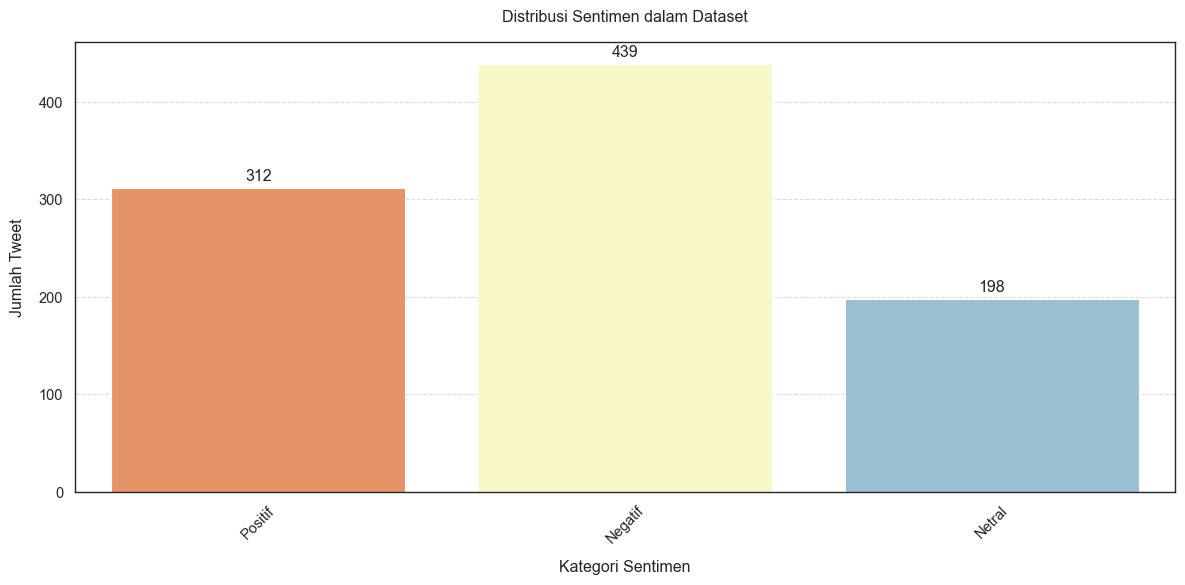

In [71]:
sns.set_style("white")
sns.set_context("paper", font_scale=1.2)

# Create figure with larger size
plt.figure(figsize=(12, 6))

# Create bar plot using seaborn
sns.countplot(data=data_label, x='Sentimen', palette='RdYlBu')

# Customize plot
plt.title('Distribusi Sentimen dalam Dataset', pad=15)
plt.xlabel('Kategori Sentimen', labelpad=10)
plt.ylabel('Jumlah Tweet', labelpad=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i in plt.gca().containers:
    plt.gca().bar_label(i, padding=3)

# Adjust layout
plt.tight_layout()

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Show plot
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_24648\2757823499.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_label, x='Aspek', palette='RdYlBu')


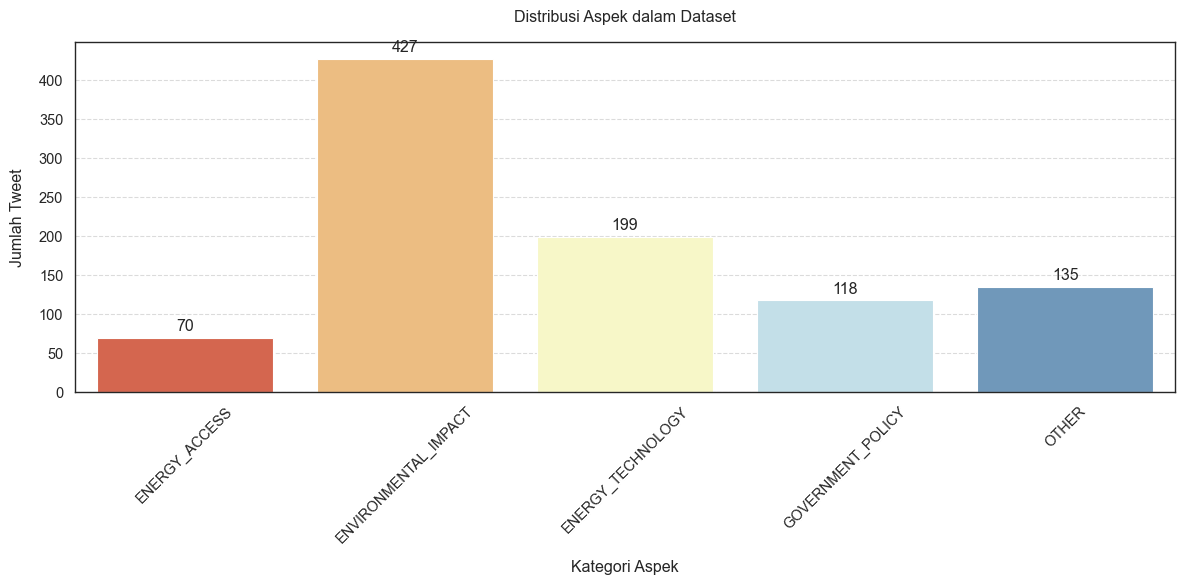

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
sns.set_context("paper", font_scale=1.2)

# Create figure with larger size
plt.figure(figsize=(12, 6))

# Create bar plot using seaborn
sns.countplot(data=data_label, x='Aspek', palette='RdYlBu')

# Customize plot
plt.title('Distribusi Aspek dalam Dataset', pad=15)
plt.xlabel('Kategori Aspek', labelpad=10)
plt.ylabel('Jumlah Tweet', labelpad=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i in plt.gca().containers:
    plt.gca().bar_label(i, padding=3)

# Adjust layout
plt.tight_layout()

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Show plot
plt.show()

Berdasarkan grafik, Kebijakan Pemerintah (GOVERNMENT_POLICY) secara jelas menjadi tema yang paling mendominasi diskusi publik tentang EBT di media sosial X. Topik mengenai Teknologi Energi (ENERGY_TECHNOLOGY) juga merupakan sorotan utama, sementara isu Akses Energi (ENERGY_ACCESS) adalah yang paling jarang dibicarakan. Hal ini mengindikasikan bahwa diskursus publik lebih terfokus pada aspek regulasi dan inovasi, dibandingkan dengan isu pemerataan energi.

>---

### **Analisis Sentimen dan Aspek dengan Indo-BERT**

Di project ini, kami menggunakan model indolem/indobert-base-uncased. Model Indo-BERT adalah salah satu model BERT yang dilatih dalam bahasa Indonesia.  Model ini didapatkan dari https://indolem.github.io/IndoBERT/. Dengan detail:
1. Uncased, semua teks diubah menjadi huruf kecil
2. Ukuran data latih kurang lebih 220 juta kata
3. Tidak dilakukan fine tuning di dalam model ini.

**Load model**

In [72]:
from transformers import BertTokenizer

# Load tokenizer dari pre-trained model
bert_tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased')

In [73]:
vocabulary = bert_tokenizer.get_vocab()
print('Panjang vocabulary:', len(vocabulary))

Panjang vocabulary: 31923


In [74]:
print('Kalimat:', data_label['Tweet_Text'][0])
print('BERT Tokenizer:', bert_tokenizer.tokenize(data_label['Tweet_Text'][0]))

Kalimat: gas bumi adalah solusi energi bersih yang terjangkau untuk rakyat indonesia. dengan kebijakan bebas ppn sesuai pp no. 49 tahun 2022, pgn memastikan tidak ada tambahan beban pajak bagi pelanggan kami
BERT Tokenizer: ['gas', 'bumi', 'adalah', 'solusi', 'energi', 'bersih', 'yang', 'terjangkau', 'untuk', 'rakyat', 'indonesia', '.', 'dengan', 'kebijakan', 'bebas', 'ppn', 'sesuai', 'pp', 'no', '.', '49', 'tahun', '202', '##2', ',', 'pg', '##n', 'memastikan', 'tidak', 'ada', 'tambahan', 'beban', 'pajak', 'bagi', 'pelanggan', 'kami']


**Encoding (mengubah satu kalimat teks mentah menjadi format numerik yang siap dipakai model Indo-BERT)**

Prosesnya:
1. Mencari max_length yang paling optimal untuk tweet tokenization, agar tidak terlalu pendek dan terlalu panjang.
1. Mengambil satu kalimat dalam data kolom Tweet_Text[0] sampai akhir
2. Menambah token spesial (seperti membuat label), [CLS] di awal dan [SEP] di akhir. CLS artinya classification dan SEP adalah separator. Default dari arsitektur BERT.
3. Max length dari token akan dihitung di kode setelah ini.

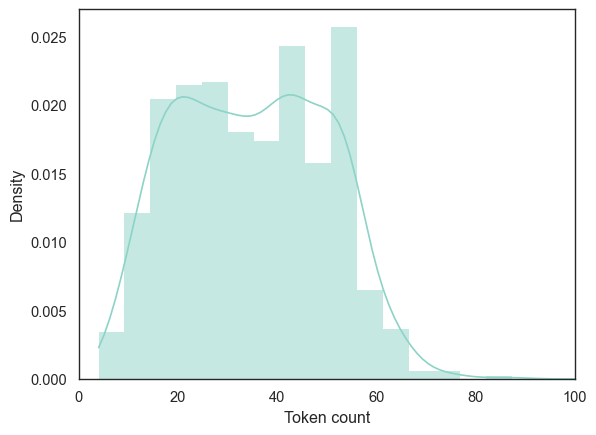

In [75]:
token_lens = []
for txt in data_label['Tweet_Text']:
  tokens = bert_tokenizer.encode(txt)
  token_lens.append(len(tokens))
sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 100]);
plt.xlabel('Token count');

Grafik ini menunjukkan bahwa sebagian besar tweet memiliki panjang di bawah 60 token. Kepadatan data sangat tinggi di rentang 20-50 token dan kemudian menurun drastis, dengan hanya sedikit sekali tweet yang memiliki panjang lebih dari 70 token. **Jadi baiknya max-length kita adalah 65**

**Split dataset menjadi tiga bagian;Train, Validation dan Test**
1. Train (70%): Untuk melatih model
2. Validation set (10%) : untuk memberikan evaluasi yang tidak bias selama proses pelatihan untuk membantu kita membuat keputusan. Bisa mencegah overfitting saat kita memantau loss pada training set dan validation set. Jika training loss terus menurun sementara validation loss mulai naik, ini adalah tanda jelas bahwa model mulai "menghafal" data latih dan tidak lagi belajar pola yang umum. Berdasarkan titik ini, kita bisa menghentikan pelatihan lebih awal untuk mendapatkan model dengan kemampuan generalisasi terbaik.
3. Test Data (20%) : untuk memberikan penilaian akhir yang paling objektif terhadap model

* Pembagian menjadi 3 dataset dikarenakan kita menggunakan Training Set untuk mengajar model dan Validation Set untuk semua proses tuning dan pemilihan model terbaik. Dengan begitu, Test Set yang tidak pernah tersentuh sama sekali dapat memberikan skor akhir yang paling baik dan objektif tentang seberapa baik performa model pada data yang benar-benar baru

In [76]:
from sklearn.model_selection import train_test_split

# 1. Persiapkan data
X = data_label['Tweet_Text'].values  # Feature
y_sentiment = data_label['Sentimen'].values  # Target sentimen
y_aspek = data_label['Aspek'].values  # Target aspek

# 2. Split menjadi train+val dan test (80:20)
X_trainval, X_test, y_sent_trainval, y_sent_test, y_asp_trainval, y_asp_test = train_test_split(
    X, y_sentiment, y_aspek,
    test_size=0.2,
    random_state=42,
    stratify=y_sentiment  # Stratifikasi berdasarkan sentimen
)

# 3. Split train+val menjadi train dan validation (90:10 dari total data)
X_train, X_val, y_sent_train, y_sent_val, y_asp_train, y_asp_val = train_test_split(
    X_trainval, y_sent_trainval, y_asp_trainval,
    test_size=0.125,  # 0.125 * 0.8 = 0.1 (10% dari total data)
    random_state=42,
    stratify=y_sent_trainval
)

# 4. Print distribusi data
print("Distribusi Data:")
print(f"Total Dataset: {len(X)}")
print(f"Training Set: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation Set: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test Set: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# 5. Cek distribusi label di setiap split
def print_distribution(y, title):
    unique, counts = np.unique(y, return_counts=True)
    print(f"\n{title}:")
    for label, count in zip(unique, counts):
        print(f"{label}: {count} ({count/len(y)*100:.1f}%)")

print_distribution(y_sent_train, "Distribusi Sentimen - Training Set")
print_distribution(y_sent_val, "Distribusi Sentimen - Validation Set")
print_distribution(y_sent_test, "Distribusi Sentimen - Test Set")

# 6. Simpan hasil split (opsional)
splits = {
    'train': {
        'texts': X_train,
        'sentiment': y_sent_train,
        'aspek': y_asp_train
    },
    'val': {
        'texts': X_val,
        'sentiment': y_sent_val,
        'aspek': y_asp_val
    },
    'test': {
        'texts': X_test,
        'sentiment': y_sent_test,
        'aspek': y_asp_test
    }
}

Distribusi Data:
Total Dataset: 949
Training Set: 664 (70.0%)
Validation Set: 95 (10.0%)
Test Set: 190 (20.0%)

Distribusi Sentimen - Training Set:
Negatif: 307 (46.2%)
Netral: 138 (20.8%)
Positif: 219 (33.0%)

Distribusi Sentimen - Validation Set:
Negatif: 44 (46.3%)
Netral: 20 (21.1%)
Positif: 31 (32.6%)

Distribusi Sentimen - Test Set:
Negatif: 88 (46.3%)
Netral: 40 (21.1%)
Positif: 62 (32.6%)


### **Modelling**

**Konfigurasi**

In [78]:
import torch

In [79]:
class Config:
    # Model settings
    MODEL_NAME = "indolem/indobert-base-uncased"  
    MAX_LENGTH = 65  
    
    # Training settings
    BATCH_SIZE = 16  
    LEARNING_RATE = 3e-5
    EPOCHS = 3
    WARMUP_RATIO = 0.1
    
    # Data settings
    TRAIN_SIZE = 0.7
    TEST_SIZE = 0.2
    VAL_SIZE = 0.1
    RANDOM_STATE = 42
    
    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()
print(f"Using device: {config.DEVICE}")

Using device: cpu


**Mapping label**

In [80]:
label2id_sentiment = {'Positif': 0, 'Netral': 1, 'Negatif': 2}
label2id_aspek = {'ENERGY_ACCESS': 0, 'ENVIRONMENTAL_IMPACT': 1, 'GOVERNMENT_POLICY': 2, 'ENERGY_TECHNOLOGY': 3, 'OTHER':4} 


**Pembuatan Custom Dataset untuk IndoBERT Multi-Task Learning**

Implementasi custom PyTorch Dataset class untuk menangani data text dan label multi-task (sentimen + aspek) yang akan digunakan dalam training model IndoBERT.

Kelas IndoBERT Dataset dirancang untuk mempersiapkan data teks dan label agar sesuai dengan format input yang diharapkan oleh model BERT di PyTorch. Kelas ini mengelola:

Fitur Utama:
1. Multi-target handling untuk sentimen dan aspek secara bersamaan
2. Dynamic tokenization menggunakan IndoBERT tokenizer
3. Label encoding otomatis dari string ke format numerik
4. Memory efficient dengan tokenisasi on-the-fly
5. Compatible dengan PyTorch DataLoader untuk batch processing


Input:
1. Raw text tweets dari dataset labeling_claude.csv (kolom Tweet_Text)
2. Label sentimen (Positif, Netral, Negatif) dari hasil labeling LLM Claude
3. Label aspek (ENERGY_ACCESS, ENVIRONMENTAL_IMPACT, etc.) dari hasil labeling LLM Claude IndoBERT tokenizer
4. Maximum sequence length (default: 65)


Output:
1. Tensor input_ids untuk BERT model
2. Attention mask dan token type IDs
3. Encoded labels siap untuk multi-task training

In [81]:
from torch.utils.data import Dataset

class IndoBERTDataset(Dataset):
    def __init__(self, texts, sentiments, aspek, tokenizer, max_len=65):
        self.texts = texts
        self.sentiments = sentiments
        self.aspek = aspek
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors='pt'
        )

        return {
        'input_ids': encoding['input_ids'].squeeze(),
        'attention_mask': encoding['attention_mask'].squeeze(),
        'token_type_ids': encoding['token_type_ids'].squeeze(),
        'sentiment': torch.tensor(label2id_sentiment[self.sentiments[idx]], dtype=torch.long),
        'aspek': torch.tensor(label2id_aspek[self.aspek[idx]], dtype=torch.long),
}



**Pembuatan Data Loader (menyajikan data dalam bentuk batch ke model selama training--model memproses 16 tweet sekaligus dalam satu kali forward pass)**

In [82]:
from torch.utils.data import DataLoader

def create_dataloaders(splits, tokenizer, batch_size=16):
    train_dataset = IndoBERTDataset(splits['train']['texts'], splits['train']['sentiment'], splits['train']['aspek'], tokenizer)
    val_dataset   = IndoBERTDataset(splits['val']['texts'], splits['val']['sentiment'], splits['val']['aspek'], tokenizer)
    test_dataset  = IndoBERTDataset(splits['test']['texts'], splits['test']['sentiment'], splits['test']['aspek'], tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader


### **Model Indo-BERT Multitask**
Multi-Task Learning (MTL) adalah pendekatan dalam machine learning di mana satu model dilatih untuk menyelesaikan beberapa tugas terkait secara bersamaan, bukan satu per satu secara terpisah.

Dalam project ini bertujuan untuk mengklasifikasikan sentimen dan aspek topik dari teks/dataset yang sama. Kedua tugas ini adalah tugas Natural Language Processing (NLP) yang saling terkait dan berbagi informasi kontekstual yang sama dari teks input. Maka dari itu, perlu pendekatan Multi-Task Learning ini.

1. Multi-Task Learning Architecture:
- Shared backbone → 1 IndoBERT untuk extract features
- 2 separate heads → sentiment classifier + aspek classifier
- Efficient → learn both tasks simultaneously

**Model Architecture**

In [83]:
import torch.nn as nn
from transformers import AutoModel

class MultiTaskIndoBERT(nn.Module):
    def __init__(self, model_name, num_sentiment_labels, num_aspek_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.sentiment_out = nn.Linear(self.bert.config.hidden_size, num_sentiment_labels)
        self.aspek_out = nn.Linear(self.bert.config.hidden_size, num_aspek_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)

        sentiment_logits = self.sentiment_out(pooled_output)
        aspek_logits = self.aspek_out(pooled_output)

        return sentiment_logits, aspek_logits


**Fungsi Pelatihan Model**

In [84]:
def train_model(model, train_loader, val_loader, device, epochs=3, lr=2e-5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            sentiment = batch['sentiment'].to(device)
            aspek = batch['aspek'].to(device)

            optimizer.zero_grad()
            sent_logits, asp_logits = model(input_ids, attention_mask, token_type_ids)

            loss1 = criterion(sent_logits, sentiment)
            loss2 = criterion(asp_logits, aspek)
            loss = loss1 + loss2

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_loss:.4f}")


**Fungsi Evaluasi Model dan Pelaporan Klasifikasi**


Fungsi ini mengevaluasi kinerja model yang sudah terlatih pada dataset yang diberikan (biasanya validation atau test set). Kode ini mengumpulkan semua prediksi model dan label sebenarnya, kemudian menghasilkan serta mencetak Classification Report terperinci untuk sentimen dan aspek. Classification Report ini mencakup metrik seperti precision, recall, dan f1-score yang penting untuk memahami performa model per kelas.

In [93]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataloader, device):
    model.eval()
    y_true_sent, y_pred_sent = [], []
    y_true_asp, y_pred_asp = [], []

    sent_confidences = []
    asp_confidences = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            sentiment = batch['sentiment'].to(device)
            aspek = batch['aspek'].to(device)

            sent_logits, asp_logits = model(input_ids, attention_mask, token_type_ids)
            
            # Confidence calculation
            sent_probs = torch.softmax(sent_logits, dim=1)
            asp_probs = torch.softmax(asp_logits, dim=1)
            
            sent_conf = torch.max(sent_probs, dim=1)[0]  # Max probability
            asp_conf = torch.max(asp_probs, dim=1)[0]
            
            # Store confidences
            sent_confidences.extend(sent_conf.cpu().numpy())
            asp_confidences.extend(asp_conf.cpu().numpy())

            sent_preds = torch.argmax(sent_logits, dim=1)
            asp_preds = torch.argmax(asp_logits, dim=1)

            y_true_sent.extend(sentiment.cpu().numpy())
            y_pred_sent.extend(sent_preds.cpu().numpy())
            y_true_asp.extend(aspek.cpu().numpy())
            y_pred_asp.extend(asp_preds.cpu().numpy())

    print("\nSentiment Classification Report:")
    print(classification_report(y_true_sent, y_pred_sent))

    print("\nAspek Classification Report:")
    print(classification_report(y_true_asp, y_pred_asp))

    print(f"\nSentiment Confidence Stats:")
    print(f"Mean: {np.mean(sent_confidences):.3f}")
    print(f"Std: {np.std(sent_confidences):.3f}")

    print(f"\nAspek Confidence Stats:")
    print(f"Mean: {np.mean(asp_confidences):.3f}")
    print(f"Std: {np.std(asp_confidences):.3f}")

    return y_true_sent, y_pred_sent, y_true_asp, y_pred_asp  


**Proses Utama Pelatihan, Evaluasi, dan Penyimpanan Model**

In [89]:
from transformers import AutoTokenizer
bert_tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)

train_loader, val_loader, test_loader = create_dataloaders(splits, bert_tokenizer)

model = MultiTaskIndoBERT(
    model_name=config.MODEL_NAME,
    num_sentiment_labels=len(np.unique(y_sentiment)),
    num_aspek_labels=len(np.unique(y_aspek))
)

train_model(model, train_loader, val_loader, device=config.DEVICE, epochs=3)

# Menyimpan model setelah training
torch.save(model.state_dict(), "indobert_multitask.pth")
print("✅ Model berhasil disimpan sebagai indobert_multitask.pth")



Epoch 1/3, Training Loss: 2.0609
Epoch 2/3, Training Loss: 1.1550
Epoch 3/3, Training Loss: 0.8378
✅ Model berhasil disimpan sebagai indobert_multitask.pth


In [94]:
true_sentiments, pred_sentiments, true_aspeks, pred_aspeks = evaluate_model(model, test_loader, config.DEVICE)



Sentiment Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88        62
           1       0.93      0.70      0.80        40
           2       0.93      0.93      0.93        88

    accuracy                           0.89       190
   macro avg       0.89      0.86      0.87       190
weighted avg       0.90      0.89      0.89       190


Aspek Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.90        16
           1       0.92      0.98      0.95        81
           2       0.90      0.76      0.83        25
           3       0.75      0.93      0.83        41
           4       1.00      0.70      0.83        27

    accuracy                           0.88       190
   macro avg       0.91      0.84      0.86       190
weighted avg       0.90      0.88      0.88       190


Sentiment Confidence Stats:
Mean: 0.866
Std: 0.144

Aspek Confide

Secara keseluruhan, model mencapai akurasi tinggi (89% sentimen, 88% aspek), menunjukkan kemampuan baik dalam mengklasifikasikan sentimen dan aspek. Meskipun demikian, terdapat ruang perbaikan pada recall untuk kelas minoritas seperti Netral (sentimen) dan beberapa kategori aspek (GOVERNMENT_POLICY, OTHER).

Model Confidence Stats menunjukkan kalau ia cukup yakin dengan hasil prediksinya, yaitu untuk Sentiment 0.86 dan Aspek 0.85

### **Perbandingan hasil dari analisis data Ground truth (LLM) dan IndoBERT**

**Pemuatan dan Pemetaan Data Berlabel dari LLM (Claude) - mengonversi label sentimen dan aspek yang berupa teks (string) dari Claude menjadi ID numerik yang konsisten dengan yang digunakan oleh model IndoBERT**

In [96]:
from sklearn.metrics import accuracy_score

# Agreement analysis (data udah ada!)
sentiment_agreement = accuracy_score(true_sentiments, pred_sentiments) * 100
aspek_agreement = accuracy_score(true_aspeks, pred_aspeks) * 100

print(f"Sentiment Agreement: {sentiment_agreement:.1f}%")
print(f"Aspek Agreement: {aspek_agreement:.1f}%")

Sentiment Agreement: 88.9%
Aspek Agreement: 88.4%


**Pemetaan Label Sentimen dan Aspek dari Teks ke Numerik**

In [ ]:
sentiment_map = {'Negatif': 0, 'Netral': 1, 'Positif': 2}
aspek_map = {
    'ENVIRONMENTAL_IMPACT': 0,
    'ENERGY_TECHNOLOGY': 1,
    'OTHER': 2,
    'GOVERNMENT_POLICY': 3,
    'ENERGY_ACCESS': 4
}

llm_sentiments = llm_test['Sentimen'].map(sentiment_map).tolist()
llm_aspeks = llm_test['Aspek'].map(aspek_map).tolist()


**Pencetakan Laporan Klasifikasi Sentimen dan Aspek**

Membandingkan label sebenarnya (ground truth dari Claude) dengan label yang diprediksi oleh model IndoBERT untuk sentimen dan aspek. Hasilnya memberikan metrik kunci seperti precision, recall, dan f1-score untuk setiap kelas, serta metrik agregat.

In [ ]:
from sklearn.metrics import classification_report

print("IndoBERT Sentiment Classification Report (vs. Claude as Ground Truth):")
print(classification_report(true_sentiments, pred_sentiments, target_names=label2id_sentiment.keys()))

print("\nIndoBERT Aspek Classification Report (vs. Claude as Ground Truth):")
print(classification_report(true_aspeks, pred_aspeks, target_names=label2id_aspek.keys()))

IndoBERT Sentiment Classification Report (vs. Claude as Ground Truth):
              precision    recall  f1-score   support

     Positif       0.88      0.94      0.91        62
      Netral       0.84      0.68      0.75        40
     Negatif       0.90      0.94      0.92        88

    accuracy                           0.88       190
   macro avg       0.87      0.85      0.86       190
weighted avg       0.88      0.88      0.88       190


IndoBERT Aspek Classification Report (vs. Claude as Ground Truth):
                      precision    recall  f1-score   support

       ENERGY_ACCESS       1.00      0.81      0.90        16
ENVIRONMENTAL_IMPACT       0.82      0.99      0.90        81
   GOVERNMENT_POLICY       0.81      0.68      0.74        25
   ENERGY_TECHNOLOGY       0.71      0.71      0.71        41
               OTHER       1.00      0.67      0.80        27

            accuracy                           0.83       190
           macro avg       0.87      0.77   

**Visualisasi Persentase Kesepakatan IndoBERT vs. LLM (Claude)**

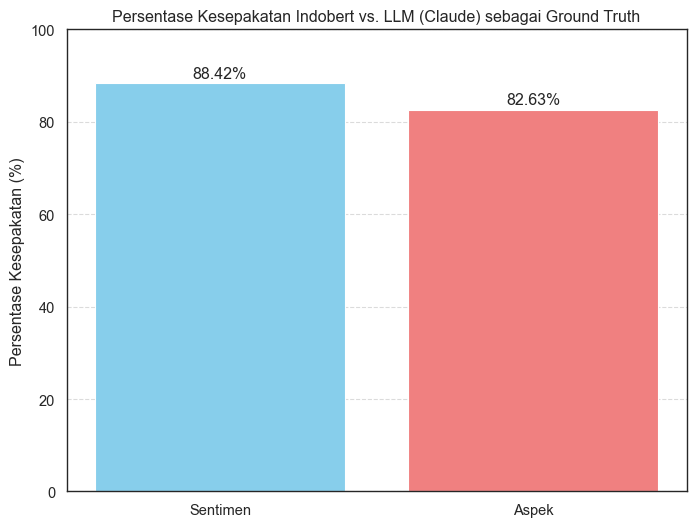

Persentase Kesepakatan Sentimen: 88.42%
Persentase Kesepakatan Aspek: 82.63%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score


# Hitung persentase kesepakatan (accuracy)
agreement_sentiment = accuracy_score(true_sentiments, pred_sentiments) * 100
agreement_aspek = accuracy_score(true_aspeks, pred_aspeks) * 100

# Data untuk bar chart
labels = ['Sentimen', 'Aspek']
agreement_percentages = [agreement_sentiment, agreement_aspek]

# Buat bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, agreement_percentages, color=['skyblue', 'lightcoral'])

# Tambahkan nilai persentase di atas setiap bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom')

plt.ylim(0, 100) # Batasi sumbu Y dari 0 sampai 100%
plt.ylabel('Persentase Kesepakatan (%)')
plt.title('Persentase Kesepakatan Indobert vs. LLM (Claude) sebagai Ground Truth')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Cetak juga nilai persentasenya
print(f"Persentase Kesepakatan Sentimen: {agreement_sentiment:.2f}%")
print(f"Persentase Kesepakatan Aspek: {agreement_aspek:.2f}%")

**Insight dan Interpretasi Model IndoBERT untuk Analisis Aspek-Sentimen Data Scraping X**
* Analisis hasil sentimen

Model menunjukkan kinerja yang sangat baik dalam klasifikasi sentimen secara keseluruhan dengan akurasi 88%. Performa untuk kelas Negatif (F1-score 0.92) dan Positif (F1-score 0.91) sangat kuat, didukung oleh nilai precision dan recall yang tinggi. Namun, terdapat tantangan pada klasifikasi sentimen Netral, yang memiliki recall terendah (0.68). Hal ini mengindikasikan bahwa model cenderung melewatkan sekitar 32% dari sampel yang sebenarnya berlabel Netral.

* Analisis hasil aspek

Untuk klasifikasi aspek, model mencapai akurasi keseluruhan 83%, menunjukkan kinerja yang baik mengingat kompleksitas tugas multi-kelas. Model sangat unggul dalam mengidentifikasi aspek ENVIRONMENTAL_IMPACT (F1-score 0.90) dengan recall yang hampir sempurna (0.99). Aspek ENERGY_ACCESS dan OTHER menunjukkan precision yang sempurna (1.00), artinya setiap kali model memprediksi kelas ini, prediksinya selalu benar.

Namun, recall untuk ENERGY_ACCESS (0.81) dan OTHER (0.67) relatif lebih rendah, menunjukkan model melewatkan beberapa instansi aspek-aspek tersebut. Aspek GOVERNMENT_POLICY juga menunjukkan recall yang lebih rendah (0.68). Sementara itu, ENERGY_TECHNOLOGY menunjukkan kinerja seimbang dengan F1-score 0.71.